In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from Core.Utils.Swin_Transformer_Classification import Swintransformer
import sys
sys.path.append('../')
from Core.Dataset.Dataloader import *
from torch.utils.data import Subset
from Core.Utils.Utility import Balanced_sampler
from monai.transforms import (EnsureChannelFirst,
                              Resize,
                              NormalizeIntensity,
                              ToTensor,
                              Resize,
                            NormalizeIntensity,
                            ResizeWithPadOrCrop,
                            SpatialPad,
                            CenterSpatialCrop)

import roc_utils as ru
from tqdm import tqdm
from roc_utils import *



class Evaluation:
    def __init__(self,tr_file,val_file,val_four_rate,save_path) -> None:
        self.tr_df = pd.read_csv(tr_file)
        self.val_df = pd.read_csv(val_file)
        #self.val_metric_df = pd.read_csv(val_four_rate)
        self.save_path = save_path

    def plot_loss(self):
        tr_loss = self.tr_df['loss'].values
        val_loss = self.val_df['loss'].values
        val_accuracy= self.val_df['accuracy'].values
        plt.plot(tr_loss,label='train')
        plt.plot(val_loss,label='val')
        plt.plot(val_accuracy,label='accuracy')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig(self.save_path)
        plt.legend()
        plt.show()

    def plot_auc(self):
        tr_auc = self.tr_df['roc_auc'].values
        val_auc = self.val_df['roc_auc'].values
        plt.plot(tr_auc,label='train')
        plt.plot(val_auc,label='val')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('AUC Values')
        plt.savefig(self.save_path)

    def plot_recall(self):
        val_recall = self.val_df['recall'].values
        val_precision = self.val_df['precision'].values
        plt.plot(val_recall,label='recall')
        plt.plot(val_precision,label='precision')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('recall-precision')
        plt.show()
    
    @staticmethod
    def calculate_average(metric_lst,metric='accuracy'):
        average_metric = []
        for metric_file in metric_lst:
            df = pd.read_csv(metric_file)
            average_metric.append(df[metric].values[-1])
        return average_metric
    
    

def load_model(model,weight_path):
    model_weight = torch.load(weight_path)['model']
    model.load_state_dict(model_weight)
    return model    

def load_data(data_path,label_path):
    
    transform_param = {"transform_methods":[
                            EnsureChannelFirst(),
                            # Data augmentation
                            #RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                            #RandRotate(range_z = 0.35, prob = 0.5),
                            #RandFlip(prob = 0.5),
                            Resize((256,256,64)),
                            SpatialPad((256,256,64)),
                            CenterSpatialCrop((256,256,64)),
                            NormalizeIntensity(),

                            # To tensor
                            ToTensor()
                            ]}



    Data = DataFiles(data_path,label_path,'HGP_Type')
    images_lst = sorted(Data.get_images())
    labels_lst = Data.get_labels()
    val_dataset =  Image_Dataset(image_files=images_lst,labels=labels_lst,transform_methods=transform_param['transform_methods'],data_aug=True,label_name=None,reader='ITKReader',
                                padding_size=None)


    val_dataloader = Data_Loader(dataset=val_dataset,batch_size=2,num_workers=0).build_vali_loader() 
    return val_dataloader


def Validation_loop(model,dataloader,criterion=torch.nn.CrossEntropyLoss()):
    """
    args:
        model: model to be trained
        dataloader: dataloader
        device: device to train on
        criterion: loss function
        visual_input: visualize input
    """
    #prepare data for training
    vali_bar = tqdm(dataloader)
    average_loss = 0

    #set metrics record
    y_pred = []
    y_true = []
    print("##################")
    print("##################")
    #model = model.to(device)
    #predict


    for i,(im,label,_) in enumerate(vali_bar):       
        #rotate and flip
        im = torch.rot90(im,k=3,dims=(2,3))
        im = torch.flip(im,[3])
        #permute to [B,C,D,H,W]
        im = im.permute(0,1,4,2,3)

        #im,label = im.to(cfg.SYSTEM.DEVICE),label.to(cfg.SYSTEM.DEVICE)
        #print('validation',im.shape,label)

        with torch.no_grad():
            output = (model(im))

            loss = criterion(output,label)
            average_loss += loss.item()

            #softmax probability
            output = torch.nn.functional.softmax(output,dim=1)
            #print('this is output',output)

    

        #softmax probability
        y_pred.append(output.cpu())
        y_true.extend(label.cpu().numpy().tolist())


        #print("this is y_pred",output,'and this is y_true',label)
        #print("this is step loss",loss)
        
        #set description for tqdm


        vali_bar.set_description(f"label{label},loss:{average_loss},out_put_prob:{output}")

        #metrics
    

    
    average_loss = average_loss/len(vali_bar)
    print('this is average loss',average_loss)
    return average_loss,y_pred,y_true
      

C:\Users\098986\AppData\Local\Temp\ipykernel_9744\1072663450.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## pure training



AttributeError: 'NoneType' object has no attribute 'write'

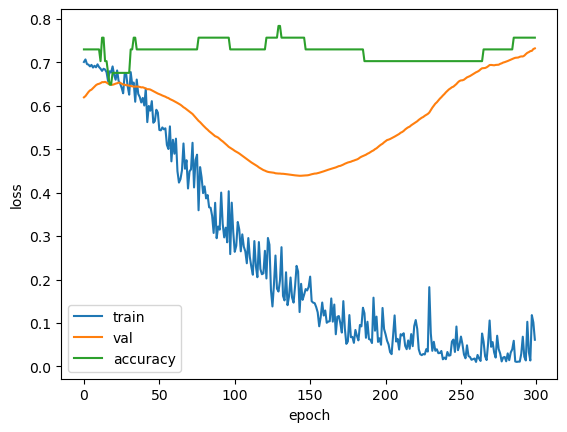

In [67]:
from pickle import NONE


eval = Evaluation(tr_file='../../Output/Resnet10/Cluster//dHGP_lower_50////0/train_metrics.csv',val_file='../../Output/Resnet10/Cluster/dHGP_lower_50///0/vali_metrics.csv',val_four_rate=None,save_path=None)
eval.plot_loss()

AttributeError: 'NoneType' object has no attribute 'write'

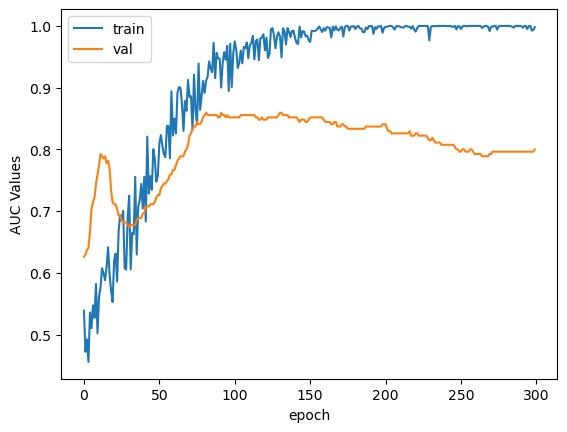

In [68]:
eval.plot_auc()

In [103]:
all_per_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/Per_tumor/per_tumor_bbx.csv')
non_pure_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/Pure_scans/non_pure_scans.csv')
all_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
# 假设 all_data 是你的 DataFrame，并且它有 'sample_id' 和 'tumor_size' 列
# all_data = pd.DataFrame(...)

# 按 'sample_id' 分组，并找到每个分组中 'tumor_size' 最大的行的索引
idx = all_per_data.groupby('sample_id')['tumor_size'].idxmax()

# 使用找到的索引来选出每个组 'tumor_size' 最大的行
max_tumor_sizes = all_per_data.loc[idx]
max_tumor_sizes.reset_index(drop=True,inplace=True)

# 显示结果



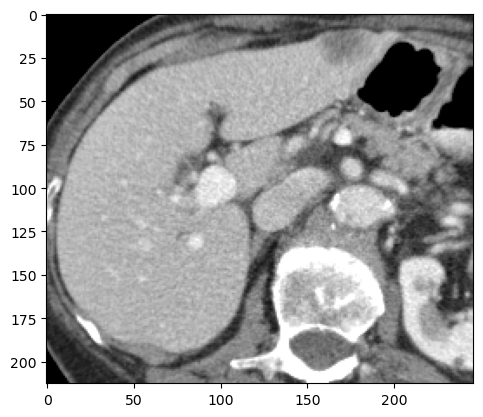

In [104]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
img_mask = sitk.ReadImage('../../Data/Mixed_HGP/largest_tm_lv_slices_window_+5/CILM_CT_100330_0000.nii.gz')
img_mask_array = sitk.GetArrayFromImage(img_mask)
plt.imshow(img_mask_array[10,:,:],cmap='gray')

In [105]:
a = pd.read_csv('../../Data/Mixed_HGP/True_Label/Per_tumor/per_tumor_bbx.csv')
a.tumor_size.quantile(0.5)

708.0

In [106]:
non_pure_id = all_data[(all_data['dHGP'] != 100) & (all_data['rHGP'] != 100) & (all_data['pHGP'] != 100)]
non_pure_with_size = max_tumor_sizes.iloc[non_pure_id.index,]
non_pure_with_size['HGP_Type'] = non_pure_id['HGP_Type']
non_pure_with_size['dHGP'] = non_pure_id['dHGP']

C:\Users\098986\AppData\Local\Temp\ipykernel_10668\70757169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_pure_with_size['HGP_Type'] = non_pure_id['HGP_Type']
C:\Users\098986\AppData\Local\Temp\ipykernel_10668\70757169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_pure_with_size['dHGP'] = non_pure_id['dHGP']


In [106]:
largest_tumo_with_size = pd.read_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/largest_tumor_+5_mask_size.csv')
pred_prob= np.load('../../Output/Resnet10/Cluster/Largest_tumor_07071/1/y_pred.npy')
True_label = pd.read_csv('../../Data/Mixed_HGP/True_Label/largest_tm_lv_+5_mask/val_cv_2.csv')


pre_prob_epoch  = pred_prob[199,:,:]
pre_prob_epoch
pre_prob_class = np.argmax(pre_prob_epoch,axis=1)

In [107]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for index,(train_index, test_index) in enumerate(skfold.split(largest_tumo_with_size,largest_tumo_with_size['HGP_Type'])):
    if index == 2:
        X_train, X_test = max_tumor_sizes.iloc[train_index], max_tumor_sizes.iloc[test_index]
        y_train, y_test = max_tumor_sizes['HGP_Type'][train_index], max_tumor_sizes['HGP_Type'][test_index]
True_label['tumor_size'] = X_test['tumor_size'].values

C:\Users\098986\AppData\Local\Temp\ipykernel_9744\1252038719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_df['correct'] = size_df['HGP_Type'] == size_df['pre']
C:\Users\098986\AppData\Local\Temp\ipykernel_9744\1252038719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_df['correct'] = size_df['HGP_Type'] == size_df['pre']
C:\Users\098986\AppData\Local\Temp\ipykernel_9744\1252038719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

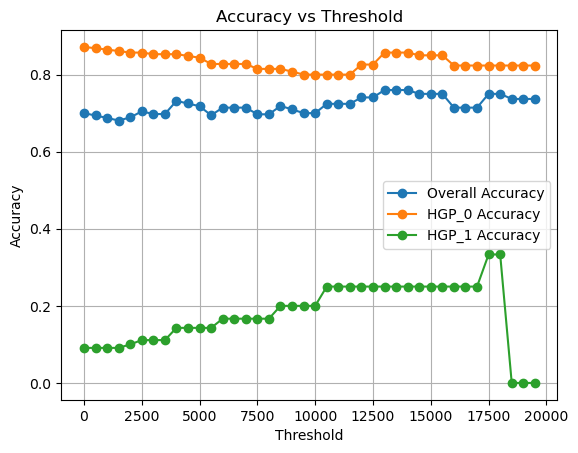

In [108]:
True_label['pre'] = pre_prob_class

def calcu_acc_size_threshold(True_label,threshold):
    size_df = True_label[True_label['tumor_size'] > threshold]
    size_df['correct'] = size_df['HGP_Type'] == size_df['pre']
    over_all_acc = size_df['correct'].sum()/len(size_df)
    HGP_0_acc = size_df[size_df['HGP_Type'] == 0]['correct'].sum()/len(size_df[size_df['HGP_Type'] == 0])
    HGP_1_acc = size_df[size_df['HGP_Type'] == 1]['correct'].sum()/len(size_df[size_df['HGP_Type'] == 1])
    #print(f'over all acc is {over_all_acc}, HGP_0 acc is {HGP_0_acc}, HGP_1 acc is {HGP_1_acc}')
    return over_all_acc,HGP_0_acc,HGP_1_acc
calcu_acc_size_threshold(True_label,threshold=0)



overall_acc_list = []
HGP_0_acc_list = []
HGP_1_acc_list = []
thresholds = range(0, 20000, 500)
for threshold in thresholds:
    overall_acc, HGP_0_acc, HGP_1_acc = calcu_acc_size_threshold(True_label, threshold=threshold)
    overall_acc_list.append(overall_acc)
    HGP_0_acc_list.append(HGP_0_acc)
    HGP_1_acc_list.append(HGP_1_acc)

plt.plot(thresholds, overall_acc_list, marker='o', label='Overall Accuracy')
plt.plot(thresholds, HGP_0_acc_list, marker='o', label='HGP_0 Accuracy')
plt.plot(thresholds, HGP_1_acc_list, marker='o', label='HGP_1 Accuracy')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
    

In [109]:
import torch
torch.cuda.is_available()

False

In [224]:
#check if correctly predicted
non_pure_with_size['correct'] = non_pure_with_size['pred'] == non_pure_with_size['HGP_Type']

C:\Users\098986\AppData\Local\Temp\ipykernel_27148\3305622986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_pure_with_size['correct'] = non_pure_with_size['pred'] == non_pure_with_size['HGP_Type']


In [225]:
non_pure_with_size_pre_25 = non_pure_with_size[non_pure_with_size['tumor_size']>= non_pure_25_quantile]
non_pure_with_size_pre_25


,Sample,min_row,min_col,min_slice,max_row,max_col,max_slice,sample,tumor_size,sample_id,...,lv_min_row,lv_max_row,lv_min_col,lv_max_col,adjusted_slice_depth,HGP_Type,dHGP,pred,correct,quantile_group
3,CILM_CT_102030_0000.nii.gz,79,123,293,169,203,374,10203,255592,3,...,48,353,93,385,81,0,72.444444,0,True,3
12,CILM_CT_111360_0000.nii.gz,137,181,425,181,218,450,11136,18172,12,...,81,385,145,407,25,0,20.000000,0,True,1
13,CILM_CT_111550_0000.nii.gz,71,246,363,119,286,387,11155,18600,13,...,38,287,121,339,24,0,40.000000,0,True,2
14,CILM_CT_114470_0000.nii.gz,110,342,320,152,382,349,11447,22716,14,...,62,339,136,391,29,0,73.500000,0,True,3
16,CILM_CT_116560_0000.nii.gz,207,189,88,250,229,122,11656,27895,16,...,62,353,147,351,34,0,5.000000,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,CILM_CT_754400_0000.nii.gz,80,104,308,164,187,372,75440,197090,228,...,29,301,77,363,64,0,0.625000,0,True,0
230,CILM_CT_766570_0000.nii.gz,91,167,313,154,230,357,76657,78470,230,...,76,356,134,329,44,0,41.041667,0,True,2
231,CILM_CT_772750_0000.nii.gz,141,170,70,185,218,91,77275,17622,231,...,110,357,112,358,21,0,92.500000,1,False,3
233,CILM_CT_798810_0000.nii.gz,104,185,310,136,214,333,79881,11868,233,...,59,357,74,340,23,0,57.500000,0,True,2


C:\Users\098986\AppData\Local\Temp\ipykernel_27148\2177242806.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_pure_with_size_pre_25['quantile_group'] = pd.qcut(non_pure_with_size['dHGP'], 4, labels=False)


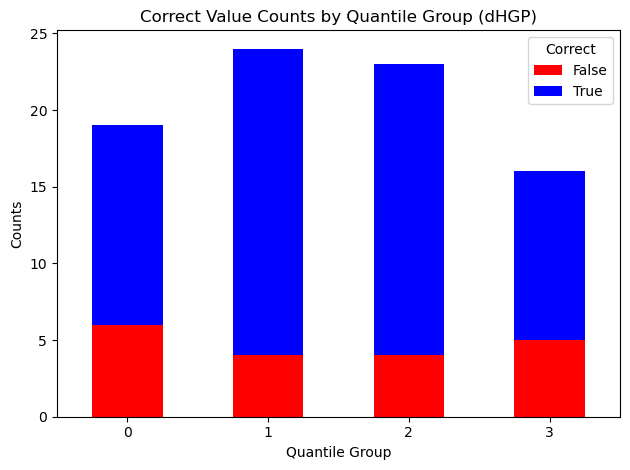

In [226]:
import matplotlib.pyplot as plt
import numpy as np

# 假设filtered_df已经按quantile分组，并且有一个'quantile'列标识每个行所属的quantile

# 计算每个quantile下True和False的计数
#non_pure_with_size['quantile_group'] = pd.qcut(non_pure_with_size['dHGP'], 4, labels=False)
non_pure_with_size_pre_25['quantile_group'] = pd.qcut(non_pure_with_size['dHGP'], 4, labels=False)

# 按quantile分组，并计算每个组内correct的True和False计数
grouped_value_counts = non_pure_with_size_pre_25.groupby('quantile_group')['correct'].value_counts().unstack()

import matplotlib.pyplot as plt

# 绘制柱状图，True和False以不同颜色表示
grouped_value_counts.plot(kind='bar', stacked=True, color=['red', 'blue'])

plt.title('Correct Value Counts by Quantile Group (dHGP)')
plt.xlabel('Quantile Group')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # 根据需要调整
plt.legend(title='Correct')
plt.tight_layout()  # 调整布局
plt.show()


# Per tumor grouped by patients analysis



In [24]:
x_4.Experiment.values == X_train.Sample.values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [61]:
#eval = Evaluation(tr_file='../../Output/Resnet10/Cluster/per_tumor_quantile_025_no_mask//4/train_metrics.csv',val_file='../../Output/Resnet10/Cluster/per_tumor_quantile_025_no_mask//4/vali_metrics.csv',val_four_rate=None,save_path=None)
def pre_label(pre_prob,epoch):
   # return prediction labels in certain epoch
    
    pre_prob_class = np.argmax(pre_prob[epoch,:,:],axis=1)
    return pre_prob_class
y_fold_0_pred = np.load('../../Output/Resnet10/Cluster/Largest_tumor_07071/2/y_pred.npy')
y_fold_0_val = pd.read_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/val_cv_2.csv')

pre_label(y_fold_0_pred,100)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
#get size
all_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/Per_tumor/per_tumor_bbx.csv')
#find the largest tumor size for each patient
idx = all_data.groupby('sample_id')['tumor_size'].idxmax()
max_tumor_sizes = all_data.loc[idx]
max_tumor_sizes.reset_index(drop=True,inplace=True)
max_tumor_sizes.to_csv('../../Data/Mixed_HGP/True_Label/Largest_Tumor/largest_tumor_+5_mask_size.csv',index=False)
import enum
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for index,(train_index, test_index) in enumerate(skfold.split(max_tumor_sizes,max_tumor_sizes['HGP_Type'])):
    if index == 2:
        X_train, X_test = max_tumor_sizes.iloc[train_index], max_tumor_sizes.iloc[test_index]
        y_train, y_test = max_tumor_sizes['HGP_Type'][train_index], max_tumor_sizes['HGP_Type'][test_index]
y_fold_0_val['tumor_size'] = X_test['tumor_size'].values

NameError: name 'y_fold_0_val' is not defined

In [63]:
max_tumor_sizes.tumor_size.describe()

count    2.490000e+02
mean     4.331814e+04
std      1.360661e+05
min      2.200000e+02
25%      3.368000e+03
50%      9.978000e+03
75%      2.595600e+04
max      1.265165e+06
Name: tumor_size, dtype: float64

In [67]:
y_fold_0_val['prediction'] = pre_label(y_fold_0_pred,99)
y_fold_0_val['correct'] = y_fold_0_val['prediction'] == y_fold_0_val['HGP_Type']
y_fold_0_val_dHGP = y_fold_0_val[y_fold_0_val['HGP_Type']==1]
y_fold_0_val_non_dHGP = y_fold_0_val[y_fold_0_val['HGP_Type']==0]

In [68]:
y_fold_0_val_pred_1 = y_fold_0_val[y_fold_0_val['prediction']==1]
y_fold_0_val_pred_0 = y_fold_0_val[y_fold_0_val['prediction']==0]

y_fold_0_val_pred_0['correct'].value_counts(),y_fold_0_val_pred_0[y_fold_0_val_pred_0['tumor_size']>20000]['correct'].value_counts()
#y_fold_0_val_non_dHGP['correct'].value_counts()

(correct
 True     35
 False     7
 Name: count, dtype: int64,
 correct
 True     16
 False     2
 Name: count, dtype: int64)

In [75]:
y_fold_0_val_pred_1['correct'].value_counts(),y_fold_0_val_pred_1[y_fold_0_val_pred_1['tumor_size']>1999]['correct'].value_counts()

(correct
 False    4
 True     4
 Name: count, dtype: int64,
 correct
 False    3
 True     3
 Name: count, dtype: int64)

In [76]:
y_fold_0_val_dHGP['correct'].value_counts(),y_fold_0_val_dHGP[y_fold_0_val_dHGP['tumor_size']>7080]['correct'].value_counts()

(correct
 False    7
 True     4
 Name: count, dtype: int64,
 correct
 False    5
 True     1
 Name: count, dtype: int64)

In [443]:
y_fold_0_val_dHGP[y_fold_0_val_dHGP['tumor_size']>=708 ]['correct'].value_counts()
y_fold_0_val_non_dHGP[y_fold_0_val_non_dHGP['tumor_size']>=708 ]['correct'].value_counts()
y_fold_0_val_pred_0[y_fold_0_val_pred_0['tumor_size']>=708 ]['correct'].value_counts()


correct
True     54
False    12
Name: count, dtype: int64

In [390]:
y_fold_0_val['correct'].value_counts()
y_fold_0_val[y_fold_0_val['tumor_size']>=708 ]['correct'].value_counts()

correct
True     65
False    25
Name: count, dtype: int64

In [371]:
y_fold_0_val_dHGP = y_fold_0_val[y_fold_0_val['HGP_Type']==1]
y_fold_0_val_pred_1 = y_fold_0_val[y_fold_0_val['prediction']==1]
y_fold_0_val_pred_1['correct']
#recall
y_fold_0_val_dHGP['correct'].value_counts( )


correct
False    23
True     10
Name: count, dtype: int64

In [370]:
#precision
y_fold_0_val_pred_1['correct'].value_counts()

correct
False    19
True     10
Name: count, dtype: int64

In [372]:
#recall of quantile > 0.5
y_fold_0_val_dHGP[y_fold_0_val_dHGP['tumor_size']>=708 ]['correct'].value_counts()

correct
False    13
True      9
Name: count, dtype: int64

In [374]:
y_fold_0_val_pred_1[y_fold_0_val_pred_1['tumor_size']>=708 ]

,Sample,min_row,min_col,min_slice,max_row,max_col,max_slice,sample,tumor_size,sample_id,...,lv_min_row,lv_max_row,lv_min_col,lv_max_col,adjusted_slice_depth,HGP_Type,data_path,mask_path,prediction,correct
3,CILM_CT_107020_0000.nii.gz,187,211,383,203,229,397,10702,2037,4,...,112,376,169,440,24,0,CILM_CT_102030_0001.nii.gz,CILM_CT_102030_0001.nii.gz,1,False
25,CILM_CT_142300_0000.nii.gz,114,324,272,135,347,286,14230,3813,41,...,80,350,152,391,24,1,CILM_CT_129270_0001.nii.gz,CILM_CT_129270_0001.nii.gz,1,True
26,CILM_CT_165550_0000.nii.gz,190,185,311,217,212,331,16555,8262,54,...,99,406,143,383,20,0,CILM_CT_138850_0000.nii.gz,CILM_CT_138850_0000.nii.gz,1,False
42,CILM_CT_209850_0000.nii.gz,128,140,333,154,168,352,20985,7940,81,...,61,381,90,367,19,0,CILM_CT_178260_0000.nii.gz,CILM_CT_178260_0000.nii.gz,1,False
46,CILM_CT_217670_0000.nii.gz,245,117,395,261,130,403,21767,918,90,...,76,317,81,367,18,0,CILM_CT_183410_0004.nii.gz,CILM_CT_183410_0004.nii.gz,1,False
49,CILM_CT_219270_0000.nii.gz,201,52,283,220,62,297,21927,845,93,...,48,311,47,288,24,1,CILM_CT_189950_0000.nii.gz,CILM_CT_189950_0000.nii.gz,1,True
51,CILM_CT_219270_0000.nii.gz,145,68,288,203,111,327,21927,32980,93,...,48,311,47,288,39,1,CILM_CT_189950_0002.nii.gz,CILM_CT_189950_0002.nii.gz,1,True
56,CILM_CT_234330_0000.nii.gz,183,234,108,245,286,159,23433,86218,106,...,23,303,130,409,51,0,CILM_CT_198760_0003.nii.gz,CILM_CT_198760_0003.nii.gz,1,False
58,CILM_CT_246500_0000.nii.gz,253,165,377,277,187,392,24650,4145,115,...,88,355,136,379,25,0,CILM_CT_206460_00010.nii.gz,CILM_CT_206460_00010.nii.gz,1,False
60,CILM_CT_260260_0000.nii.gz,155,267,303,184,299,327,26026,11715,124,...,96,407,139,334,24,1,CILM_CT_211670_0000.nii.gz,CILM_CT_211670_0000.nii.gz,1,True


In [373]:
#precision of quantile >0.5
y_fold_0_val_pred_1[y_fold_0_val_pred_1['tumor_size']>=708 ]['correct'].value_counts()

correct
False    12
True      9
Name: count, dtype: int64

In [20]:
import pandas as pd
import numpy as np
import scipy.stats
import os
results_path = 'c:/Users/098986/Intership_CILM/Output/Resnet10/Cluster/largest_tumor_07071_mask/'
folds = ['0','1','2','3','4']
roc = []
accuracy = []
f1_score = []
for fold in folds:
    path = os.path.join(results_path, fold, 'vali_metrics.csv')
    result = pd.read_csv(path)
    # Get the row with the largest ROC value
    max_roc_row = result.iloc[199,:]
    
    # Append the largest ROC and corresponding accuracy and F1 score to the lists
    roc.append(max_roc_row['roc_auc'])
    accuracy.append(max_roc_row['accuracy'])
    f1_score.append(max_roc_row['f1_score'])

# Assuming you want to see the results
print("ROC:", roc)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)


roc = np.array(roc)
accuracy = np.array(accuracy)
f1_score = np.array(f1_score)

# Function to calculate the confidence interval
def calculate_confidence_interval(data):
    mean = np.mean(data)
    sem = scipy.stats.sem(data)  # Standard error of the mean
    z_score = 1.96  # Z-score for 95% confidence interval
    margin_of_error = z_score * sem
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound

# Calculate confidence intervals
roc_mean, roc_lower, roc_upper = calculate_confidence_interval(roc)
accuracy_mean, accuracy_lower, accuracy_upper = calculate_confidence_interval(accuracy)
f1_score_mean, f1_score_lower, f1_score_upper = calculate_confidence_interval(f1_score)

# Print results
print(f"ROC: {roc_mean:.2f} [{roc_lower:.2f}, {roc_upper:.2f}]")
print(f"Accuracy: {accuracy_mean:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]")
print(f"F1 Score: {f1_score_mean:.2f} [{f1_score_lower:.2f}, {f1_score_upper:.2f}]")

ROC: [0.57, 0.515, 0.7342657342657343, 0.5944055944055945, 0.582051282051282]
Accuracy: [0.72, 0.7, 0.82, 0.72, 0.7346938775510204]
F1 Score: [0.3636363636363636, 0.1176470588235294, 0.5714285714285713, 0.0, 0.3157894736842105]
ROC: 0.60 [0.53, 0.67]
Accuracy: 0.74 [0.70, 0.78]
F1 Score: 0.27 [0.08, 0.47]


In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import os
results_path = 'c:/Users/098986/Intership_CILM/Output/Resnet10/Cluster/Largest_tumor_07071_mask/'
folds = ['1','2','3','4']
roc = []
accuracy = []
f1_score = []
for fold in folds:
    path = os.path.join(results_path, fold, 'vali_metrics.csv')
    result = pd.read_csv(path)
    # Get the row with the largest ROC value
    max_roc_row = result.iloc[199,:]
    
    # Append the largest ROC and corresponding accuracy and F1 score to the lists
    roc.append(max_roc_row['roc_auc'])
    accuracy.append(max_roc_row['accuracy'])
    f1_score.append(max_roc_row['f1_score'])

# Assuming you want to see the results
print("ROC:", roc)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)


roc = np.array(roc)
accuracy = np.array(accuracy)
f1_score = np.array(f1_score)

# Function to calculate the confidence interval
def calculate_confidence_interval(data):
    mean = np.mean(data)
    sem = scipy.stats.sem(data)  # Standard error of the mean
    z_score = 1.96  # Z-score for 95% confidence interval
    margin_of_error = z_score * sem
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound

# Calculate confidence intervals
roc_mean, roc_lower, roc_upper = calculate_confidence_interval(roc)
accuracy_mean, accuracy_lower, accuracy_upper = calculate_confidence_interval(accuracy)
f1_score_mean, f1_score_lower, f1_score_upper = calculate_confidence_interval(f1_score)

# Print results
print(f"ROC: {roc_mean:.2f} [{roc_lower:.2f}, {roc_upper:.2f}]")
print(f"Accuracy: {accuracy_mean:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]")
print(f"F1 Score: {f1_score_mean:.2f} [{f1_score_lower:.2f}, {f1_score_upper:.2f}]")

ROC: [0.515, 0.7342657342657343, 0.5944055944055945, 0.582051282051282]
Accuracy: [0.7, 0.82, 0.72, 0.7346938775510204]
F1 Score: [0.1176470588235294, 0.5714285714285713, 0.0, 0.3157894736842105]
ROC: 0.61 [0.52, 0.70]
Accuracy: 0.74 [0.69, 0.80]
F1 Score: 0.25 [0.01, 0.50]


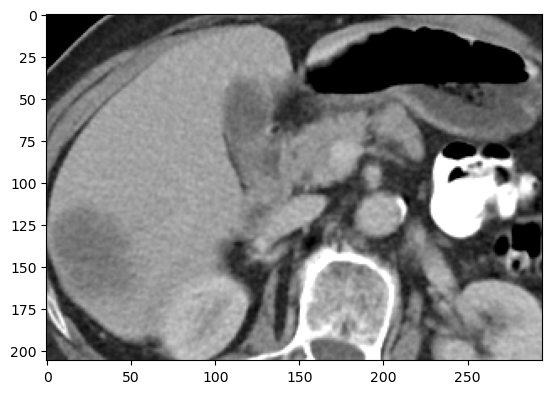

In [9]:
import SimpleITK as sitk
import matplotlib.pyplot as plt


In [ ]:
def Validation_loop(model,dataloader,criterion):
    """
    args:
        model: model to be trained
        dataloader: dataloader
        device: device to train on
        criterion: loss function
        visual_input: visualize input
    """
    #prepare data for training
    vali_bar = tqdm(dataloader)
    average_loss = 0

    #set metrics record
    y_pred = []
    y_true = []
    print("##################")
    print("##################")
    #model = model.to(device)
    #predict


    for i,(im,label,_) in enumerate(vali_bar):       
        #rotate and flip
        im = torch.rot90(im,k=3,dims=(2,3))
        im = torch.flip(im,[3])
        #permute to [B,C,D,H,W]
        im = im.permute(0,1,4,2,3)

        #im,label = im.to(cfg.SYSTEM.DEVICE),label.to(cfg.SYSTEM.DEVICE)
        #print('validation',im.shape,label)

        with torch.no_grad():
            output = (model(im))

            loss = criterion(output,label)
            average_loss += loss.item()

            #softmax probability
            output = torch.nn.functional.softmax(output,dim=1)
            #print('this is output',output)

    

        #softmax probability
        y_pred.append(output.cpu())
        y_true.extend(label.cpu().numpy().tolist())


        #print("this is y_pred",output,'and this is y_true',label)
        #print("this is step loss",loss)
        
        #set description for tqdm


        vali_bar.set_description(f"label{label},loss:{average_loss},out_put_prob:{output}")

        #metrics
    

    
    average_loss = average_loss/len(vali_bar)
    print('this is average loss',average_loss)
    return average_loss,y_pred,y_true
      

In [266]:
import os
import sys
sys.path.append('../')
from Core.Utils import Swin_Transformer_Classification
from Core.Dataset.Dataloader import Image_Dataset,Data_Loader,DataFiles
import torch

model = Swin_Transformer_Classification.Swintransformer(img_size=(64,256,256),in_channels=1,out_channels=1)

model.load_state_dict(torch.load('../../Output/SwingTransformer/Cluster/Test_03/01/best_metric_41.pth')['model'])

<All keys matched successfully>

In [267]:
from monai.transforms import (EnsureChannelFirst,
                              Resize,
                              SpatialPad,
                              CenterSpatialCrop,
                              NormalizeIntensity,
                              ToTensor) 
from Core.model import Validation
from tqdm import tqdm
transform_param_val = {"transform_methods":[EnsureChannelFirst(),
                                                    Resize((256,256,-1)),
                                                    SpatialPad((256,256,64)),
                                                    CenterSpatialCrop((256,256,64)),
                                                    NormalizeIntensity(),
                                                    ToTensor()]}
                
data_path = '../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_windowed/'
label_path = '../../Data/Mixed_HGP/True_Label/val_cv_0.csv'
Data = DataFiles(data_path,label_path,'HGP_Type')
images_lst = sorted(Data.get_images())
labels_lst = Data.get_labels()

val_dataset =  Image_Dataset(image_files=images_lst,labels=labels_lst,transform_methods=transform_param_val['transform_methods'],data_aug=True,label_name=None,reader='ITKReader',
                            padding_size=None)


val_dataloader = Data_Loader(dataset=val_dataset,batch_size=2,num_workers=0).build_vali_loader() 
loss = torch.nn.CrossEntropyLoss()

c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\monai\transforms\io\array.py:205: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


In [ ]:
loss,y_pred,y_true = Validation_loop(model,val_dataloader,loss)

In [269]:
np.save('../../Output/SwingTransformer/Cluster/Test_03/01/y_pred_41.npy',y_pred)
np.save('../../Output/SwingTransformer/Cluster/Test_03/01/y_true_41.npy',y_true)

# check prediction


In [58]:
import pandas as pd
import numpy as np


In [59]:
import pandas as pd

# 假设val_prediction是你的原始DataFrame

# 初始化一个空列表来存储新的行
def clean_df(val_prediction,epoch_range=(1,50)):
    new_rows = []

    # 按每两行进行遍历处理
    for i in range(0, len(val_prediction), 2):
        # 移除非数字字符并合并当前行和下一行的数据
        row1 = val_prediction.iloc[i, 0].replace('[', '').replace(']', '').split()
        row2 = val_prediction.iloc[i + 1, 0].replace('[', '').replace(']', '').split()
        combined_row = list(map(int, row1 + row2))

        # 添加到新行的列表中
        new_rows.append(combined_row)

    # 创建一个新的DataFrame
    new_df = pd.DataFrame(new_rows)

    #chosse rows within ranges
    new_df = new_df.iloc[epoch_range[0]:epoch_range[1],:]

    
    return new_df


In [186]:
fold_non_overfit_range = ((4,56),(11,51),(4,53),(22,61))

In [232]:
val_fold_5 = pd.read_csv('../../Data/Mixed_HGP/True_Label/val_cv_4.csv')
val_fold_5_dict = {i:None for i in val_fold_5.Experiment}
epoch_range = (22,61)
val_prediction = pd.read_table('../../Output/SwingTransformer/Cluster/Test_03/05/vali_pred_.txt',header=None)
val_prediction = clean_df(val_prediction,epoch_range=epoch_range)
val_fold_5_pred = val_prediction.apply(lambda x: x.value_counts().index[0],axis=1)

In [233]:
# mode() 返回的是一个DataFrame，我们取第0行，因为可能存在多个众数，我们只取第一个
final_predictions = val_prediction.mode().iloc[0]

# 将最终预测转换为列表
final_predictions_list = final_predictions.tolist()


In [234]:

# 输出最终预测列表
for keys,value in zip(val_fold_5_dict.keys(),final_predictions_list):
    val_fold_5_dict[keys] = value


val_fold_5_true = val_fold_5['HGP_Type'].values

for keys,index in zip(val_fold_5_dict.keys(),val_fold_5_true):
    if val_fold_5_dict[keys] == val_fold_5_true[index]:
        val_fold_5_dict[keys] = 1
    else:
        val_fold_5_dict[keys] = 0

In [235]:
val_fold_5_dict

{'CT_10785': 1,
 'CT_11111': 1,
 'CT_11136': 0,
 'CT_11447': 1,
 'CT_12190': 0,
 'CT_13419': 1,
 'CT_13999': 1,
 'CT_14299': 1,
 'CT_15820': 1,
 'CT_16555': 0,
 'CT_17684': 0,
 'CT_18041': 1,
 'CT_19439': 1,
 'CT_19752': 1,
 'CT_20342': 0,
 'CT_20378': 0,
 'CT_20646': 1,
 'CT_20985': 0,
 'CT_21114': 1,
 'CT_21399': 0,
 'CT_21919': 0,
 'CT_23726': 0,
 'CT_23857': 0,
 'CT_25615': 1,
 'CT_27354': 0,
 'CT_29793': 1,
 'CT_29799': 0,
 'CT_29977': 1,
 'CT_31460': 0,
 'CT_31851': 1,
 'CT_32378': 0,
 'CT_32505': 0,
 'CT_32653': 0,
 'CT_32915': 1,
 'CT_33488': 0,
 'CT_33791': 1,
 'CT_33891': 1,
 'CT_39229': 1,
 'CT_40447': 1,
 'CT_50410': 1,
 'CT_50926': 1,
 'CT_54293': 1,
 'CT_55046': 1,
 'CT_79221': 1,
 'CT_80259': 1,
 'CT_81233': 1,
 'CT_82801': 0,
 'CT_88827': 0,
 'CT_94912': 1}

In [236]:
merged_4_folds = {**val_fold_2_dict,**val_fold_3_dict,**val_fold_4_dict,**val_fold_5_dict}
four_fold_pre = pd.DataFrame.from_dict(merged_4_folds,orient='index',columns=['pred'])
four_fold_pre.to_csv('../../Output/SwingTransformer/Cluster/Test_03/four_fold_pre.csv')

In [237]:
all_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv')
all_Data_dhgp = all_data[all_data['HGP_Type'] == 1]
all_Data_non_dhgp = all_data[all_data['HGP_Type'] == 0]


In [238]:

all_correct_Data = four_fold_pre[four_fold_pre['pred'] == 1]
all_incorrect_Data = four_fold_pre[four_fold_pre['pred'] == 0]

all_correct_dhgp_data = all_Data_dhgp[all_Data_dhgp['Experiment'].isin(all_correct_Data.index)]
all_incorrect_dhgp_data = all_Data_dhgp[all_Data_dhgp['Experiment'].isin(all_incorrect_Data.index)]

all_correct_non_dhgp_data = all_Data_non_dhgp[all_Data_non_dhgp['Experiment'].isin(all_correct_Data.index)]
all_incorrect_non_dhgp_data = all_Data_non_dhgp[all_Data_non_dhgp['Experiment'].isin(all_incorrect_Data.index)]

In [248]:
all_incorrect_non_dhgp_data

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
0,3932332,CRLM_137,CT_10033,4,0.000000,30.000000,70.000000,0,Lever meta's 2.0 B31f,84259.93629,...,20060906.0,F,073Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,9814
6,328205,CRLM_008,CT_10871,3,0.000000,1.666667,98.333333,0,Abdomen 2.0 B31f,144404.12050,...,20100222.0,M,069Y,Sensation 10,FFS,SIEMENS,"""2""",B31s,NaN,3048
7,741673,CRLM_029,CT_10929,6,0.000000,5.000000,95.000000,0,ONCO ThAbd 1.5 B70f,112745.11970,...,20141028.0,M,061Y,Sensation 64,HFS,SIEMENS,"""1.5""",B70f,NaN,18782
12,6684059,CRLM_226,CT_11136,797,60.000000,20.000000,20.000000,0,NaN,85413.00000,...,NaN,M,066Y,Mx8000 IDT 16,FFS,Philips,"""2.0""",B,NaN,56132
15,6927879,CRLM_242,CT_11655,2,8.500000,25.500000,66.000000,0,Thorax 3mm,145655.00000,...,NaN,M,031Y,Brilliance 64,FFS,Philips,"""3.00""",B,NaN,3150
20,4560823,CRLM_157,CT_12017,2,0.000000,20.000000,80.000000,0,Th. tumor 5.0 B31f,90557.63021,...,20040419.0,M,063Y,Sensation 16,HFS,SIEMENS,"""5""",B31f,NaN,4812
21,4344349,CRLM_150,CT_12190,3,0.000000,76.666667,23.333333,0,Veneus Sft Tissue 4.0 CE,170146.85000,...,20170117.0,M,077Y,Aquilion,FFS,TOSHIBA,"""4.0""",FC08,NaN,746
22,4033021,CRLM_141,CT_12276,9,0.000000,95.000000,5.000000,0,NaN,144225.95000,...,NaN,M,083Y,Aquilion,HFS,TOSHIBA,"""3.0""",FC10,NaN,3954
25,275031,CRLM_004,CT_12906,3,0.000000,99.000000,1.000000,0,Abd 5.0 mm,113333.00000,...,NaN,M,070Y,Brilliance 64,FFS,Philips,"""5.00""",B,NaN,678
27,637720,CRLM_023,CT_12957,8,22.500000,1.250000,76.250000,0,Lever 60 sec 2.0 B31f,134222.01100,...,20090921.0,F,073Y,Sensation 10,FFS,SIEMENS,"""2""",B31f,NaN,25078


In [249]:
all_correct_dhgp_data_tumor_size = all_correct_dhgp_data['tumor_size'].values
all_incorrect_dhgp_data_tumor_size = all_incorrect_dhgp_data['tumor_size'].values

all_correct_non_dhgp_data_tumor_size = all_correct_non_dhgp_data['tumor_size'].values
all_incorrect_non_dhgp_data_tumor_size = all_incorrect_non_dhgp_data['tumor_size'].values

all_folds_data_tumor_size = all_data[all_data['Experiment'].isin(four_fold_pre.index)]['tumor_size'].values

KeyError: 49

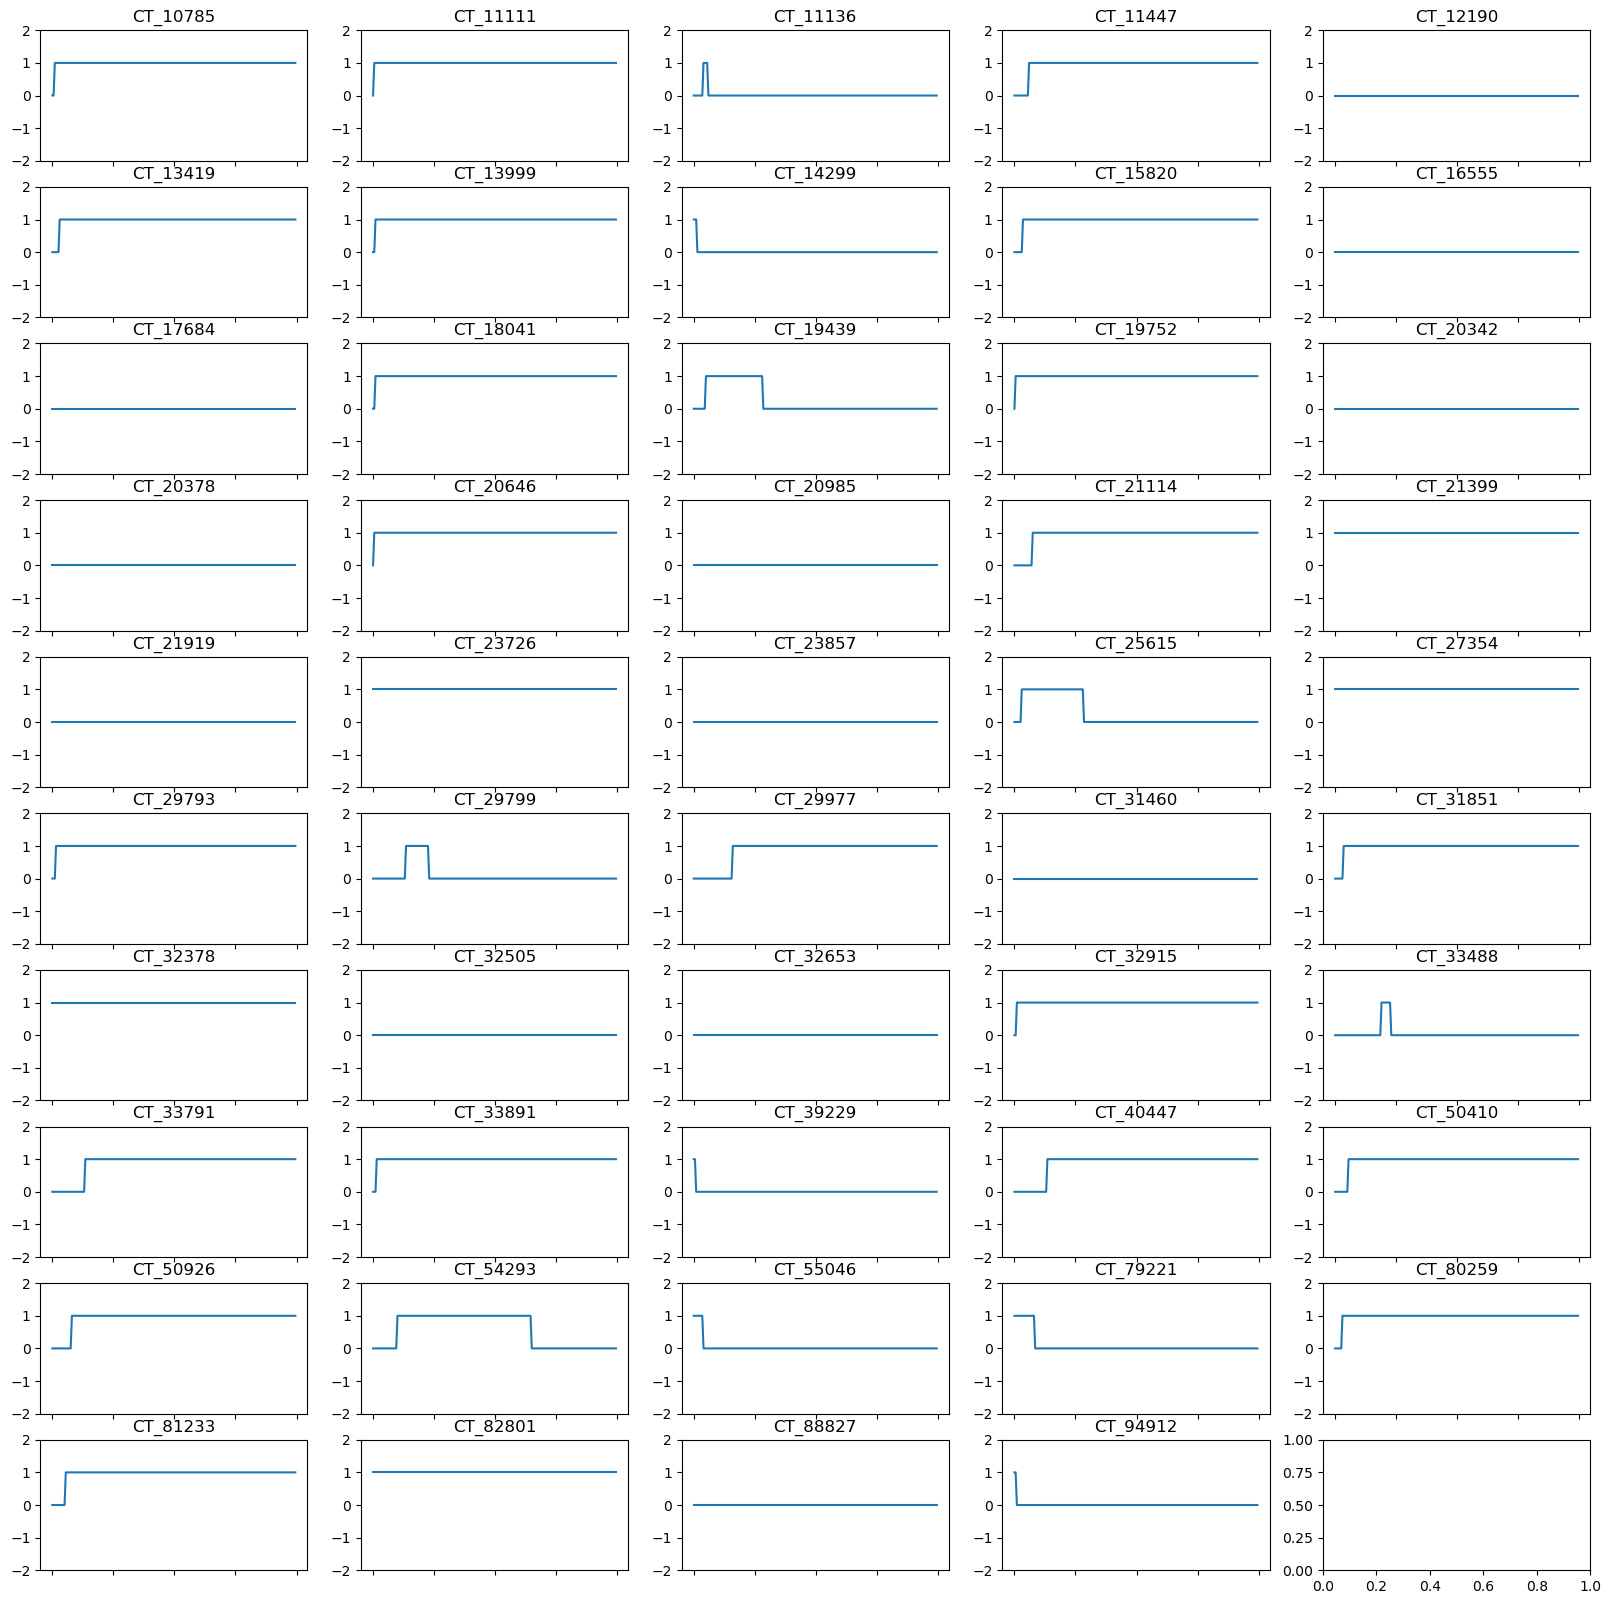

In [277]:
#subplots 10 x 5
#set y axis to 0-1
import matplotlib.pyplot as plt

# 假设 pre_dict 是您的数据字典
# pre_dict = {0: data0, 1: data1, ..., 49: data49}

fig, ax = plt.subplots(10, 5, figsize=(20, 20))
sample_name_lst = true_label_df.Experiment.values.tolist()
for i in range(10):
    for j in range(5):
        # 绘制每个子图
        ax[i, j].plot(pre_dict[i * 5 + j])
        ax[i, j].set_title(f'{sample_name_lst[i * 5 + j]}')
        
        # 设置 y 轴的范围为 0 到 1
        ax[i, j].set_ylim([-2, 2])
        ax[i, j].set_xticklabels([])
plt.tight_layout()  # 调整子图的布局
plt.show()    

In [294]:
def label_prediction(dict,exp_name,correct=1):
    """
    input pre_dict, and regarding experiment name
    """
    dict[exp_name] = correct
    return dict

prediction_correct = label_prediction(prediction_correct,'CT_94912',correct=0)

In [296]:
#save the dict
import pickle
with open('../../Output/SwingTransformer/Cluster/Test_03/bad_prediction.pkl', 'wb') as f:
    pickle.dump(prediction_correct, f)

In [297]:
#extract 0 values from dict
import numpy as np

prediction_correct = {k:v for k,v in prediction_correct.items() if v == 0}
prediction_correct_2folds = list(prediction_correct.keys())

In [212]:
data_info.tumor_size.values.tolist()
#quantile of tumor size
np.quantile(data_info.tumor_size.values.tolist(),0.25)

3048.0

In [316]:
#get exp in list
data_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv')
bad_pre_size = data_info.loc[data_info['Experiment'].isin(prediction_correct_2folds)]
all_size = data_info


In [327]:
sum(bad_pre_size.tumor_size.values < 7000)

38

In [348]:
np.quantile(data_info.dHGP.values,0.25)
#calculate quantile but except dHGP=100
np.quantile(data_info[data_info['dHGP'] != 100].dHGP.values,0.85)

81.000000002

In [361]:
np.quantile(data_info.tumor_size.values,0.5)

7528.0

In [376]:
bad_pre_size_data = bad_pre_size.tumor_size.values
all_size_data = all_size.tumor_size.values


[7, 3, 4, 2, 3, 0, 0, 2, 0, 1] [5, 4, 1, 4, 1, 1, 3, 1, 0, 0]


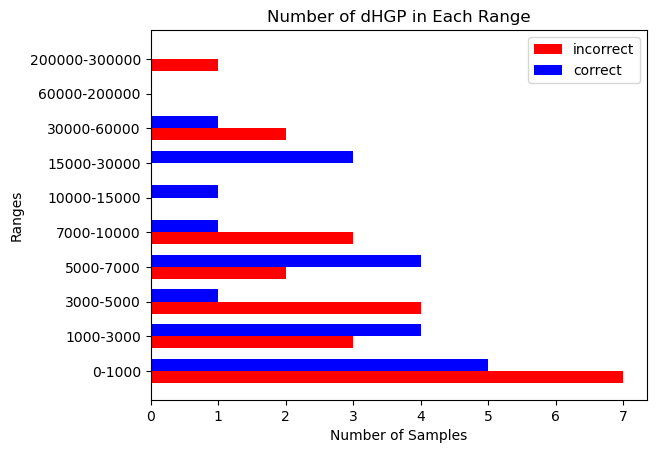

In [277]:

import numpy as np
import matplotlib.pyplot as plt


ranges = [(0,1000),(1000, 3000), (3000, 5000), (5000,7000),(7000, 10000),(10000,15000), (15000, 30000), (30000, 60000),(60000,200000),(200000,300000)]

def plot_sample_distribution(data1, data2, ranges, label1='Data 1', label2='Data 2'):
    """
    绘制两组数据在给定区间内的样本分布条形图。
    
    :param data1: 第一组数据，NumPy数组或列表。
    :param data2: 第二组数据，NumPy数组或列表。
    :param ranges: 定义的区间列表，形如 [(start1, end1), (start2, end2), ...]。
    :param label1: 第一组数据的标签。
    :param label2: 第二组数据的标签。
    """
    # 计算每个区间的样本数
    def count_in_ranges(data, ranges):
        counts = []
        for r in ranges:
            count = ((data >= r[0]) & (data < r[1])).sum()
            counts.append(count)
        return counts

    # 计算两组数据的区间样本数
    data1_counts = count_in_ranges(data1, ranges)
    data2_counts = count_in_ranges(data2, ranges)
    print(data1_counts,data2_counts)

    # 创建条形图
    y_positions = np.arange(len(ranges))
    bar_width = 0.35

    plt.barh(y_positions - bar_width/2, data1_counts, bar_width, label=label1, color='red')
    plt.barh(y_positions + bar_width/2, data2_counts, bar_width, label=label2, color='blue')

    # 设置 y 轴的刻度标签
    plt.yticks(y_positions, [f"{r[0]}-{r[1]}" for r in ranges])

    plt.xlabel('Number of Samples')
    plt.ylabel('Ranges')
    plt.title('Number of dHGP in Each Range')
    plt.legend()

    plt.show()

# 使用示例
plot_sample_distribution(all_incorrect_dhgp_data_tumor_size,all_correct_dhgp_data_tumor_size, ranges, label1='incorrect', label2='correct')


In [279]:
all_correct_non_dhgp_data

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
1,4327749,CRLM_147,CT_10043,2,32.500000,22.500000,45.000000,0,ABDOMEN 2/2,141238.00000,...,NaN,M,NaN,Mx8000 IDT 10,FFS,Philips,"""2.00""",C,NaN,2504
3,3985131,CRLM_139,CT_10203,7,27.555556,72.444444,0.000000,0,Th-Abd. alg. 2.0 B20f,142730.55920,...,20060131.0,M,061Y,Sensation 16,HFS,SIEMENS,"""2""",B20f,NaN,260068
4,8202397,CRLM_282,CT_10702,2,0.000000,1.111111,98.888889,0,ONCO ThAbd 3.0 B31f,115626.45590,...,20170921.0,M,071Y,Sensation 64,HFS,SIEMENS,"""3""",B31f,NaN,12020
5,8037018,CRLM_276,CT_10785,2,0.000000,0.000000,100.000000,0,5.0 CE Venous/Phase Body,134820.05000,...,20170120.0,F,070Y,Aquilion ONE,FFS,TOSHIBA,"""5.0""",FC08,NaN,163408
11,969857,CRLM_038,CT_11111,4,12.500000,87.500000,0.000000,0,lever port. f. 5.0 B30f,85040.23599,...,20051125.0,M,NaN,Volume Zoom,HFS,SIEMENS,"""5""",B30f,NaN,3914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,6289359,CRLM_209,CT_81233,4976,0.000000,2.500000,97.500000,0,NaN,161422.00000,...,NaN,M,067Y,Mx8000 IDT 10,FFS,Philips,"""2.0""",C,NaN,1058
238,5253957,CRLM_179,CT_83958,9,17.500000,82.500000,0.000000,0,3F Lever port 2.0 B31f,132531.61930,...,20090622.0,M,066Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,5440
239,6734378,CRLM_229,CT_86475,4,0.000000,0.000000,100.000000,0,C+ Body 3.0 CE,93833.50000,...,20130913.0,F,057Y,Aquilion ONE,FFS,TOSHIBA,"""3.0""",FC08,NaN,12912
241,3346249,CRLM_117,CT_87770,2,0.000000,0.000000,100.000000,0,Thx-tumor 5.0 B30f,113739.69950,...,20060109.0,M,NaN,Volume Zoom,HFS,SIEMENS,"""5""",B30f,NaN,9154


In [261]:
def count_in_ranges(data, ranges):
        counts = []
        for r in ranges:
            count = ((data >= r[0]) & (data < r[1])).sum()
            counts.append(count)
        return counts
count_in_ranges(all_correct_non_dhgp_data_tumor_size,ranges)

[18, 22, 23, 16, 20]

In [160]:
from scipy.stats import mannwhitneyu
mannwhitneyu(all_incorrect_non_dhgp_data_tumor_size,all_correct_non_dhgp_data_tumor_size)

MannwhitneyuResult(statistic=3011.0, pvalue=0.3964016231980819)

In [517]:
three_folds_incorrect_dhgp_tumor

array([ 7674,   354, 11846,   892,   710, 15194,  1262, 27476,   924,
        9918,  5830,  6626, 35126,  2802,   330,  3598,   938],
      dtype=int64)

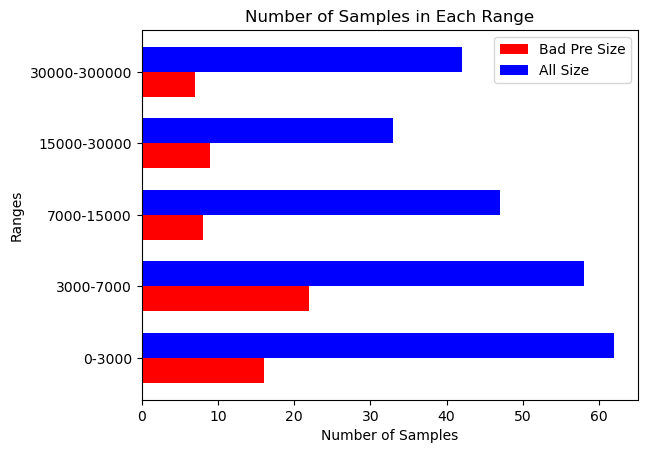

In [377]:
# 定义区间

# 计算每个区间的样本数
def count_in_ranges(data, ranges):
    counts = []
    for r in ranges:
        count = ((data >= r[0]) & (data < r[1])).sum()
        counts.append(count)
    return counts

bad_pre_counts = count_in_ranges(bad_pre_size_data, ranges)
all_size_counts = count_in_ranges(all_size_data, ranges)

# 创建条形图
y_positions = np.arange(len(ranges))
bar_width = 0.35

plt.barh(y_positions - bar_width/2, bad_pre_counts, bar_width, label='Bad Pre Size', color='red')
plt.barh(y_positions + bar_width/2, all_size_counts, bar_width, label='All Size', color='blue')

# 设置 y 轴的刻度标签
plt.yticks(y_positions, [f"{r[0]}-{r[1]}" for r in ranges])

plt.xlabel('Number of Samples')
plt.ylabel('Ranges')
plt.title('Number of Samples in Each Range')
plt.legend()

plt.show()

In [404]:
bad_pre_size.iloc[[23,25,38,45,61,11,29,35],]

,PID,Subject,Experiment,Scan,pHGP,dHGP,rHGP,HGP_Type,Series_description,acquisition_time,...,seriesdate_y,gender,age,model_name,patient_position,manufacturer,slice_thickness,convolution_kernel,prediction,tumor_size
76,771262,CRLM_030,CT_20378,3,0.0,80.000000,20.000000,0,ABD. 5/5,151518.0000,...,NaN,F,081Y,Brilliance 64,FFS,Philips,"""5.00""",B,NaN,1926
81,483623,CRLM_015,CT_20985,2,0.0,80.000000,20.000000,0,IV 60 sec Portaal,105532.1500,...,20110909.0,M,064Y,Aquilion ONE,FFS,TOSHIBA,"""5.0""",FC02,NaN,3326
146,9036978,CRLM_306,CT_27925,13,15.0,81.666667,3.333333,0,D70 Onco ThAb 1.0 Bl57 3,133244.2280,...,20180109.0,F,058Y,SOMATOM Edge Plus,HFS,SIEMENS,"""1""","['Bl57f', '3']",NaN,340560
179,9032247,CRLM_305,CT_32505,3-CT1,0.0,98.333333,1.666667,0,Abdomen 2.0 B31f,164344.2707,...,20100116.0,M,055Y,Sensation 10,FFS,SIEMENS,"""2""",B31s,NaN,14080
231,8325505,CRLM_287,CT_77275,1,0.0,92.500000,7.500000,0,NaN,145733.0000,...,NaN,M,080Y,Mx8000 IDT 16,FFS,Philips,"""2.0""",B,NaN,33618
31,5978471,CRLM_199,CT_13416,6,0.0,85.000000,15.000000,0,ONCO ThAbd 1.5 B70f,114438.3126,...,20151119.0,M,045Y,Sensation 64,HFS,SIEMENS,"""1.5""",B70f,NaN,6360
101,9087307,CRLM_308,CT_22958,7,20.0,77.500000,2.500000,0,"3F thx,abd port 2.0 B31f",102638.9854,...,20070628.0,M,079Y,Sensation 16,HFS,SIEMENS,"""2""",B31f,NaN,1148626
131,2995387,CRLM_106,CT_26568,3,0.0,76.666667,23.333333,0,ABD AX 4MM,155645.0000,...,NaN,M,054Y,Brilliance 40,HFS,Philips,"""4.00""",B,NaN,28796


In [413]:
from scipy.stats import mannwhitneyu
mannwhitneyu(bad_pre_size.tumor_size.values,all_size.tumor_size.values)
# delete bad pre size from all size
all_size_no_bad = all_size[~all_size['Experiment'].isin(prediction_correct_2folds)]

In [420]:
bad_pre_size_dhgp = bad_pre_size[bad_pre_size['dHGP'] == 100]
bad_pre_size_non_dhgp = bad_pre_size[bad_pre_size['dHGP'] != 100]
all_size_dhgp = all_size[all_size['dHGP'] == 100]
all_size_non_dhgp = all_size[all_size['dHGP'] != 100]

In [424]:
mannwhitneyu(bad_pre_size_non_dhgp.tumor_size.values,all_size_non_dhgp.tumor_size.values)

mannwhitneyu(bad_pre_size_non_dhgp.dHGP.values,all_size_non_dhgp.dHGP.values)

MannwhitneyuResult(statistic=4800.5, pvalue=0.3841260517382219)

In [416]:
mannwhitneyu(bad_pre_size.tumor_size.values,all_size_no_bad.tumor_size.values)

mannwhitneyu(bad_pre_size.dHGP.values,all_size_no_bad.dHGP.values)


MannwhitneyuResult(statistic=6989.5, pvalue=0.0302651908628372)

In [398]:
bad_pre_size.dHGP.values

array([ 30.        ,   5.        , 100.        ,  20.        ,
        25.5       ,  20.        ,  76.66666667, 100.        ,
       100.        ,   1.25      ,  31.66666667,  85.        ,
        56.66666667,  17.5       , 100.        ,   5.        ,
         0.        ,  12.5       ,   0.        , 100.        ,
        26.66666667,  25.        ,   0.        ,  80.        ,
       100.        ,  80.        ,   2.5       , 100.        ,
       100.        ,  77.5       ,  70.        , 100.        ,
       100.        ,  56.66666667,   0.        ,  76.66666667,
       100.        ,   0.        ,  81.66666667,  50.        ,
         0.        ,  55.        ,  90.        ,  18.33333333,
       100.        ,  98.33333333,  49.375     ,   5.        ,
        80.        , 100.        , 100.        ,  20.        ,
       100.        ,  65.        ,  35.        , 100.        ,
       100.        ,  30.        ,  33.33333333,   0.625     ,
       100.        ,  92.5       ,  65.        , 100.  

In [369]:
np.quantile(bad_pre_size.tumor_size,0.75)

17076.5

Text(0, 0.5, 'tumor size')

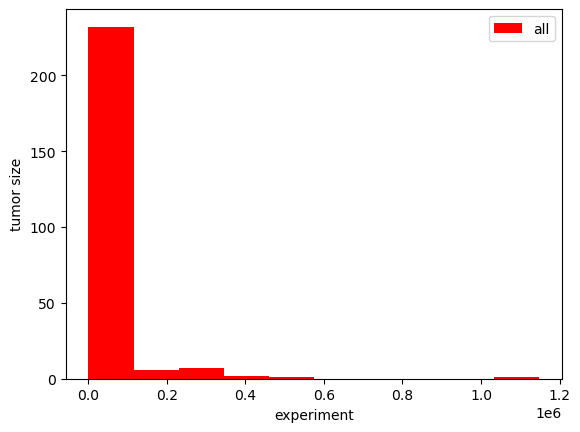

In [307]:
#plt.hist(bad_pre_size,label='bad prediction')
plt.hist(all_size,label='all',color='red')
plt.legend()
plt.xlabel('experiment')
plt.ylabel('tumor size')

In [330]:
#quantile of tumor size
np.quantile(data_info.tumor_size.values.tolist(),0.25)

3048.0

In [314]:
np.asarray(bad_pre_size)<= 3048

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True])

In [201]:
data_dHGP = data_info[data_info['HGP_Type'] == 1]
data_all_HGP = data_info['HGP_Type'].values.tolist()
data_dHGP_name = data_dHGP.Experiment.values.tolist()
#add suffix 0 to each name
data_dHGP_name = [i+'0' for i in data_dHGP_name]
data_all_HGP_name = [i +'0' for i in data_info.Experiment.values.tolist()]

In [202]:
import SimpleITK as sitk
import os
pre_fix = 'CILM_'
suffix = '.nii.gz'
data_dHGP_name = [pre_fix+i+suffix for i in data_dHGP_name]
data_all_HGP_name = [pre_fix+i+suffix for i in data_all_HGP_name]
data_folder = os.listdir('../../Data/Mixed_HGP/Mxied_HGP_mask/')
tumor_size = {i:None for i in data_all_HGP_name}
for img_file in data_all_HGP_name:

    img_path = os.path.join('../../Data/Mixed_HGP/Mxied_HGP_mask/',img_file)
    img = sitk.ReadImage(img_path)
    img = sitk.GetArrayFromImage(img)
    img[img==1] = 0
    tumor_size[img_file] = img.sum()


In [194]:

for img_file in data_all_HGP_name:

    img_path = os.path.join('../../Data/Mixed_HGP/Mxied_HGP_mask/',img_file)
    img = sitk.ReadImage(img_path)
    img = sitk.GetArrayFromImage(img)
    img[img==1] = 0
    tumor_size[img_file] = img.sum()


val_4_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/val_cv_0.csv')
val_4_info = val_4_info[val_4_info['HGP_Type'] == 1]
val_4_data_name = val_4_info.Experiment.values.tolist()
val_4_data_name = [i+'0' for i in val_4_data_name]
val_4_data_name = [pre_fix+i+suffix for i in val_4_data_name]


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../../Data/Mixed_HGP/Mxied_HGP_mask/CT_100330" does not exist.

In [204]:
data_info['tumor_size'] = tumor_size.values()

In [207]:
data_info.to_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info_with_tumor.csv',index=False)

In [206]:
tumor_size

{'CILM_CT_100330.nii.gz': 9814,
 'CILM_CT_100430.nii.gz': 2504,
 'CILM_CT_101040.nii.gz': 1850,
 'CILM_CT_102030.nii.gz': 260068,
 'CILM_CT_107020.nii.gz': 12020,
 'CILM_CT_107850.nii.gz': 163408,
 'CILM_CT_108710.nii.gz': 3048,
 'CILM_CT_109290.nii.gz': 18782,
 'CILM_CT_109300.nii.gz': 7674,
 'CILM_CT_109540.nii.gz': 376,
 'CILM_CT_109630.nii.gz': 5132,
 'CILM_CT_111110.nii.gz': 3914,
 'CILM_CT_111360.nii.gz': 56132,
 'CILM_CT_111550.nii.gz': 18924,
 'CILM_CT_114470.nii.gz': 23270,
 'CILM_CT_116550.nii.gz': 3150,
 'CILM_CT_116560.nii.gz': 13848,
 'CILM_CT_117840.nii.gz': 13708,
 'CILM_CT_119090.nii.gz': 680,
 'CILM_CT_119760.nii.gz': 13412,
 'CILM_CT_120170.nii.gz': 4812,
 'CILM_CT_121900.nii.gz': 746,
 'CILM_CT_122760.nii.gz': 3954,
 'CILM_CT_125750.nii.gz': 10754,
 'CILM_CT_127240.nii.gz': 354,
 'CILM_CT_129060.nii.gz': 678,
 'CILM_CT_129270.nii.gz': 6006,
 'CILM_CT_129570.nii.gz': 25078,
 'CILM_CT_131630.nii.gz': 20330,
 'CILM_CT_132360.nii.gz': 1176,
 'CILM_CT_133290.nii.gz': 8249

In [264]:
for i in val_4_data_name:
    print(tumor_size[i])

376
1176
2318
2424
28490
17746
65474
31960
2474
5020


In [95]:
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve
y_pred_1 = np.stack([y.detach().cpu().numpy() for y in y_pred],axis=0)[:,:,1].reshape(-1)
#Prob of samples more
y_true_1 = np.array(y_true).reshape(-1)
#with more thresholds

fpr,tpr,thresholds = roc_curve(y_true_1,y_pred_1,drop_intermediate=True)
roc_auc = roc_auc_score(y_true_1,y_pred_1)
#plot roc curve
plt.plot(fpr,tpr,label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

AttributeError: 'numpy.float32' object has no attribute 'detach'

In [111]:
fpr,tpr

(array([0.        , 0.        , 0.05128205, 0.05128205, 0.12820513,
        0.12820513, 0.30769231, 0.30769231, 0.35897436, 0.35897436,
        0.38461538, 0.38461538, 0.51282051, 0.51282051, 0.56410256,
        0.56410256, 0.61538462, 0.61538462, 0.8974359 , 0.8974359 ,
        1.        ]),
 array([0.        , 0.09090909, 0.09090909, 0.27272727, 0.27272727,
        0.36363636, 0.36363636, 0.45454545, 0.45454545, 0.54545455,
        0.54545455, 0.63636364, 0.63636364, 0.72727273, 0.72727273,
        0.81818182, 0.81818182, 0.90909091, 0.90909091, 1.        ,
        1.        ]))

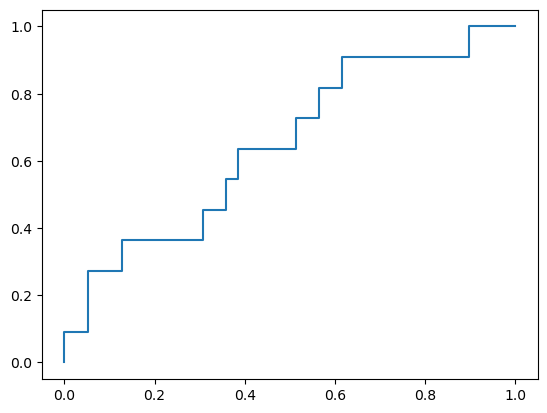

In [107]:
plt.plot(fpr,tpr)

array([0.        , 0.09090909, 0.09090909, 0.27272727, 0.27272727,
       0.36363636, 0.36363636, 0.45454545, 0.45454545, 0.54545455,
       0.54545455, 0.63636364, 0.63636364, 0.72727273, 0.72727273,
       0.81818182, 0.81818182, 0.90909091, 0.90909091, 1.        ,
       1.        ])

In [97]:
thresholds

array([       inf, 0.62786925, 0.60064906, 0.57187915, 0.53852826,
       0.5372427 , 0.49775353, 0.4928783 , 0.48763266, 0.4862657 ,
       0.4856193 , 0.48331326, 0.46506658, 0.46488842, 0.4563023 ,
       0.45571586, 0.45194674, 0.4519    , 0.41225085, 0.40647322,
       0.3738449 ], dtype=float32)

In [97]:

train_loss = train_loss['loss'].values.tolist()
val_loss = val_loss['loss'].values.tolist()

train_loss = [round(float(i),3) for i in train_loss]
val_loss = [round(float(i),3) for i in val_loss]

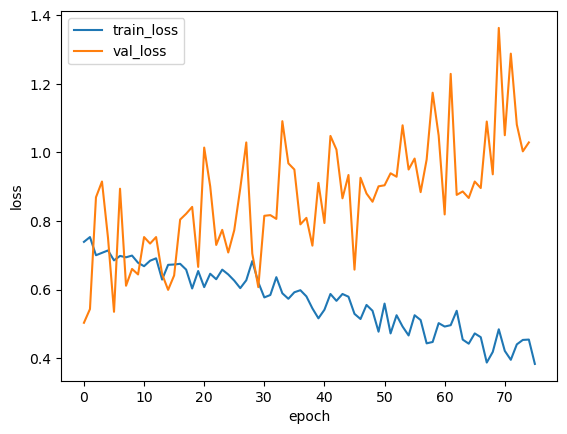

In [98]:
epoch_axis = range(100)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [88]:
train_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01train_Four_rate.csv')

train_acc = train_rates.iloc[1::6]['accuracy']

val_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01vali_four rates.csv')

val_acc = val_rates.iloc[1::6]['accuracy']

In [73]:
train_rates.iloc[1::6]['precision']

1      0.3157894736842105
7                  0.4375
13     0.5526315789473685
19                    0.5
25     0.4492753623188406
              ...        
691    0.7108433734939759
697    0.8188976377952756
703    0.7666666666666667
709    0.7685185185185185
715    0.7619047619047619
Name: precision, Length: 120, dtype: object

In [89]:
train_precision = train_rates.iloc[1::6]['precision'].values.tolist()
train_recall = train_rates.iloc[1::6]['recall'].values.tolist()

train_precision = [round(float(i),3) for i in train_precision]
train_recall = [round(float(i),3) for i in train_recall]


val_precision = val_rates.iloc[1::6]['precision'].values.tolist()
val_recall = val_rates.iloc[1::6]['recall'].values.tolist()

val_precision = [round(float(i),3) for i in val_precision]
val_recall = [round(float(i),3) for i in val_recall]


In [85]:
train_recall

[0.22,
 0.368,
 0.612,
 0.49,
 0.344,
 0.61,
 0.527,
 0.688,
 0.718,
 0.653,
 0.535,
 0.651,
 0.615,
 0.713,
 0.505,
 0.566,
 0.541,
 0.92,
 0.57,
 0.747,
 0.337,
 0.494,
 0.663,
 0.726,
 0.588,
 0.819,
 0.745,
 0.608,
 0.739,
 0.689,
 0.564,
 0.614,
 0.573,
 0.789,
 0.596,
 0.574,
 0.698,
 0.691,
 0.596,
 0.667,
 0.649,
 0.657,
 0.553,
 0.74,
 0.774,
 0.644,
 0.554,
 0.506,
 0.769,
 0.629,
 0.638,
 0.739,
 0.66,
 0.75,
 0.804,
 0.673,
 0.602,
 0.578,
 0.564,
 0.702,
 0.762,
 0.726,
 0.729,
 0.663,
 0.693,
 0.762,
 0.698,
 0.667,
 0.673,
 0.724,
 0.75,
 0.802,
 0.591,
 0.798,
 0.765,
 0.694,
 0.8,
 0.677,
 0.752,
 0.75,
 0.755,
 0.781,
 0.707,
 0.78,
 0.833,
 0.765,
 0.769,
 0.778,
 0.779,
 0.74,
 0.765,
 0.765,
 0.824,
 0.813,
 0.753,
 0.818,
 0.89,
 0.806,
 0.767,
 0.796,
 0.819,
 0.735,
 0.733,
 0.827,
 0.707,
 0.776,
 0.823,
 0.844,
 0.825,
 0.758,
 0.781,
 0.785,
 0.827,
 0.864,
 0.76,
 0.678,
 0.92,
 0.86,
 0.783,
 0.873]

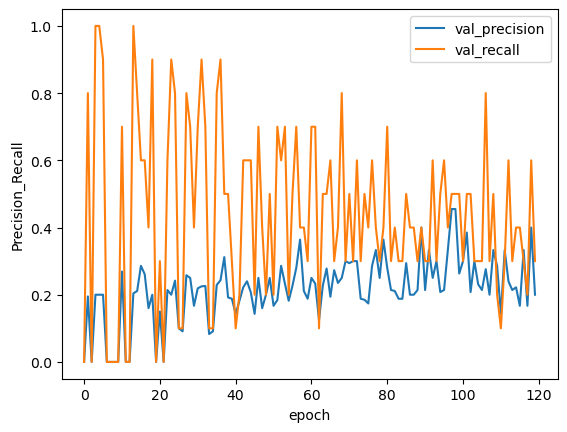

In [93]:
epoch_axis = range(120)
plt.plot(val_precision,label='val_precision')
plt.plot(val_recall,label='val_recall')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('Precision_Recall')
plt.legend()

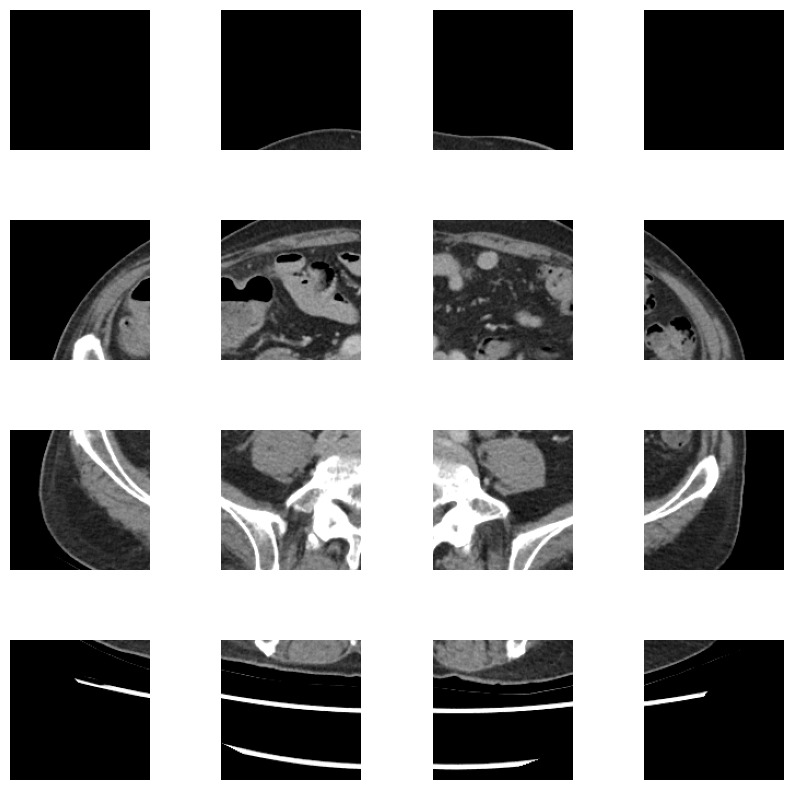

In [284]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_image_in_patches(image_path, patch_size=128, spacing=0.5):
    # 打开图像并转换为numpy数组
    img = Image.open(image_path)
    img_np = np.array(img)

    # 获取图像尺寸
    h, w = img_np.shape[:2]

    # 计算每个维度的切片数
    x_patches = w // patch_size
    y_patches = h // patch_size

    # 创建绘图
    fig, axs = plt.subplots(y_patches, x_patches, figsize=(10, 10))
    
    # 为了避免在边界上的图像信息丢失，我们可以稍微调整每个 patch 的位置
    for i in range(y_patches):
        for j in range(x_patches):
            # 计算每个 patch 的坐标
            x_start = j * patch_size
            y_start = i * patch_size
            x_end = min(x_start + patch_size, w)
            y_end = min(y_start + patch_size, h)

            # 提取 patch
            patch = img_np[y_start:y_end, x_start:x_end]

            # 绘制 patch
            axs[i, j].imshow(patch)
            axs[i, j].axis('off')  # 关闭坐标轴

    # 调整子图之间的间距
    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    plt.savefig('../../Output/Thesis/Graph/model_arc.png')
    plt.show()

# 使用示例
image_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075_windowed_2D/Study_id_CT_101040_slice_22.png'
plot_image_in_patches(image_path)


In [12]:
import numpy as np
import scipy.stats as stats

def calculate_confidence_interval(scores, confidence_level=0.95):
    """
    计算给定分数的95%置信区间。
    
    参数:
    - scores: 包含多个folds验证结果的数组。
    - confidence_level: 置信水平，默认为0.95。
    
    返回:
    - mean: 分数的平均值。
    - ci_lower: 置信区间的下界。
    - ci_upper: 置信区间的上界。
    """
    # 计算均值和标准误差
    mean = np.mean(scores)
    se = stats.sem(scores)  # sem计算标准误差
    
    # 计算置信区间
    ci_range = stats.t.interval(confidence_level, len(scores)-1, loc=mean, scale=se)
    ci_lower, ci_upper = ci_range
    
    return mean, ci_lower, ci_upper

# 示例数据：5个folds的验证结果
scores = np.array([0.3157,0.1538,0.1538])
mean, ci_lower, ci_upper = calculate_confidence_interval(scores)

print(f"Mean: {mean:.3f}, 95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")
#


Mean: 0.208, 95% CI: (-0.024, 0.440)


# analysies of pure train non-pure prediction

In [13]:
import numpy as np
import pandas as pd
def load_pre_label(np_array,epoch=None):
    #return y_pred by probability
    y_pred_prob = np_array[epoch,:,:]
    y_pred = np.argmax(y_pred_prob,axis=1)
    return y_pred
    
vali_true_data = pd.read_csv('../../Data/Mixed_HGP/True_Label/Pure_scans/non_pure_scans.csv')
vali_pred = np.load('../../Output/Resnet10/Cluster/largest_tumor_train_pure_val_non_pure/0/y_pred.npy')

C:\Users\098986\AppData\Local\Temp\ipykernel_17396\2066140051.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [124]:
y_pred_label = load_pre_label(vali_pred,epoch=140)


sum(vali_true_data.iloc[y_pred_label == 1,].dHGP < 50)

30

In [125]:
sum(vali_true_data.dHGP < 50)

96